<a href="https://colab.research.google.com/github/nguyenhoang47/AI/blob/main/gender_and_age_detection2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.utils import load_img
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, Input
import numpy as np
import random
import matplotlib.pyplot as plt
import os 
import seaborn as sns
import warnings 
from tqdm.notebook import tqdm 
warnings.filterwarnings('ignore')


In [2]:
BASE_DIR = '/content/drive/MyDrive/anhmang/tuoi' #là đường dẫn của thư mục chứa các file ảnh và cũng là đường dẫn mà bạn sẽ sử dụng để đọc dữ liệu ảnh.
age_labels = []   #danh sách để lưu giữ nhãn (age và gender) và đường dẫn ảnh.
gender_labels = []
image_paths = []

image_filenames = os.listdir(BASE_DIR)   # lấy ra các file ảnh có trong thư mục `BASE_DIR`.
random.shuffle(image_filenames)  # xáo trộn thứ tự các tập tin ảnh để đảm bảo chuỗi đầu vào ngẫu nhiên.


for image in tqdm(image_filenames):
  image_path = os.path.join(BASE_DIR, image)  # tạo đường dẫn đầy đủ đến một tập tin ảnh.
  img_components = image.split('_')   # chia tập tin ảnh thành các thành phần cách nhau bằng dấu _
  age_label = int(img_components[0])    #giá trị đầu tiên được chuyển đổi sang kiểu số nguyên và coi đó là nhãn tuổi, giá trị thứ hai được chuyển đổi sang kiểu số nguyên và coi đó là nhãn giới tính.
  gender_label = int(img_components[1])   #giới tính 

  # đường dẫn ảnh, nhãn tuổi và nhãn giới tính được thêm vào các danh sách tương ứng để sử dụng cho mô hình huấn luyện detech tuổi và giới tính.
  age_labels.append(age_label)
  gender_labels.append(gender_label)
  image_paths.append(image_path)

  0%|          | 0/1090 [00:00<?, ?it/s]

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
print(f'Number of age_labels: {len(age_labels)}, Number of gender_labels: {len(gender_labels)}, Number of image_paths: {len(image_paths)}')


Number of age_labels: 1090, Number of gender_labels: 1090, Number of image_paths: 1090


In [5]:
gender_mapping = {
    1: 'Female',
    0: 'Male'
}

In [6]:
import pandas as pd 
df = pd.DataFrame()
df['image_path'], df['age'], df['gender'] = image_paths, age_labels, gender_labels
df.head(5)

,image_path,age,gender
0,/content/drive/MyDrive/anhmang/tuoi/96_1_0_201...,96,1
1,/content/drive/MyDrive/anhmang/tuoi/4_1_1_2017...,4,1
2,/content/drive/MyDrive/anhmang/tuoi/4_0_3_2016...,4,0
3,/content/drive/MyDrive/anhmang/tuoi/23_1_2_201...,23,1
4,/content/drive/MyDrive/anhmang/tuoi/29_1_0_201...,29,1


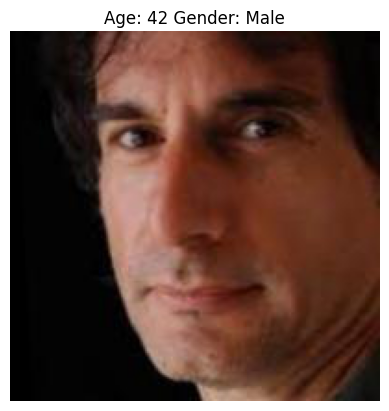

In [7]:
from PIL import Image  #Đoạn code này sử dụng thư viện PIL (Python Imaging Library) để load 1 ảnh từ đường dẫn trong dataframe `df`. 

rand_index = random.randint(0, len(image_paths))  #Biến `rand_index` được sử dụng để chọn ngẫu nhiên 1 ảnh từ danh sách các đường dẫn trong dataframe.
age = df['age'][rand_index]    # đoạn code này lấy ra giá trị `age` và `gender` của ảnh này từ dataframe `df`
gender = df['gender'][rand_index]
IMG = Image.open(df['image_path'][rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')  #Biến `gender_mapping` cho cải thien kết quả hiển thị cho các giá trị giới tính.
plt.axis('off')   
plt.imshow(IMG)

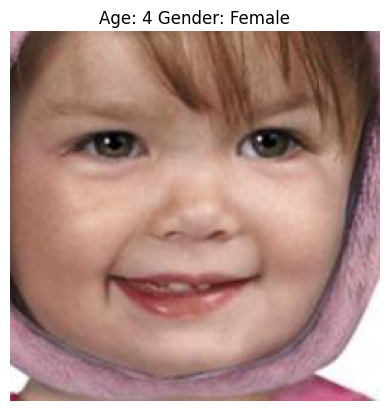

In [8]:
from PIL import Image

rand_index = random.randint(0, len(image_paths) - 1)
age = age_labels[rand_index]
gender = gender_labels[rand_index]
IMG = Image.open(image_paths[rand_index])
plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
plt.axis('off')
plt.imshow(IMG)


<Axes: xlabel='age', ylabel='Density'>

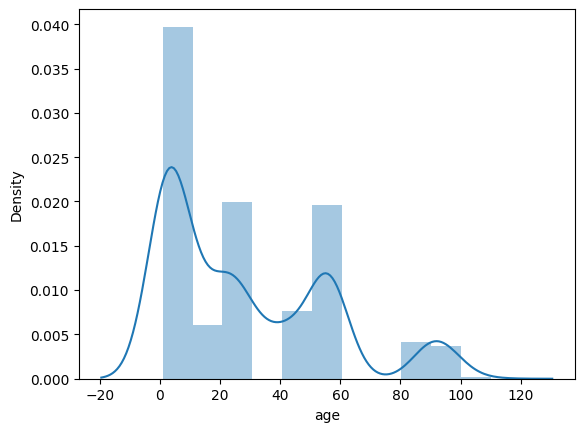

In [9]:
 sns.distplot(df['age'])

<Axes: ylabel='count'>

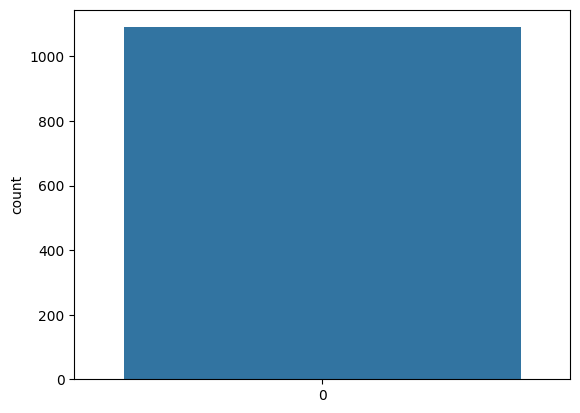

In [10]:
sns.countplot(df['gender'])

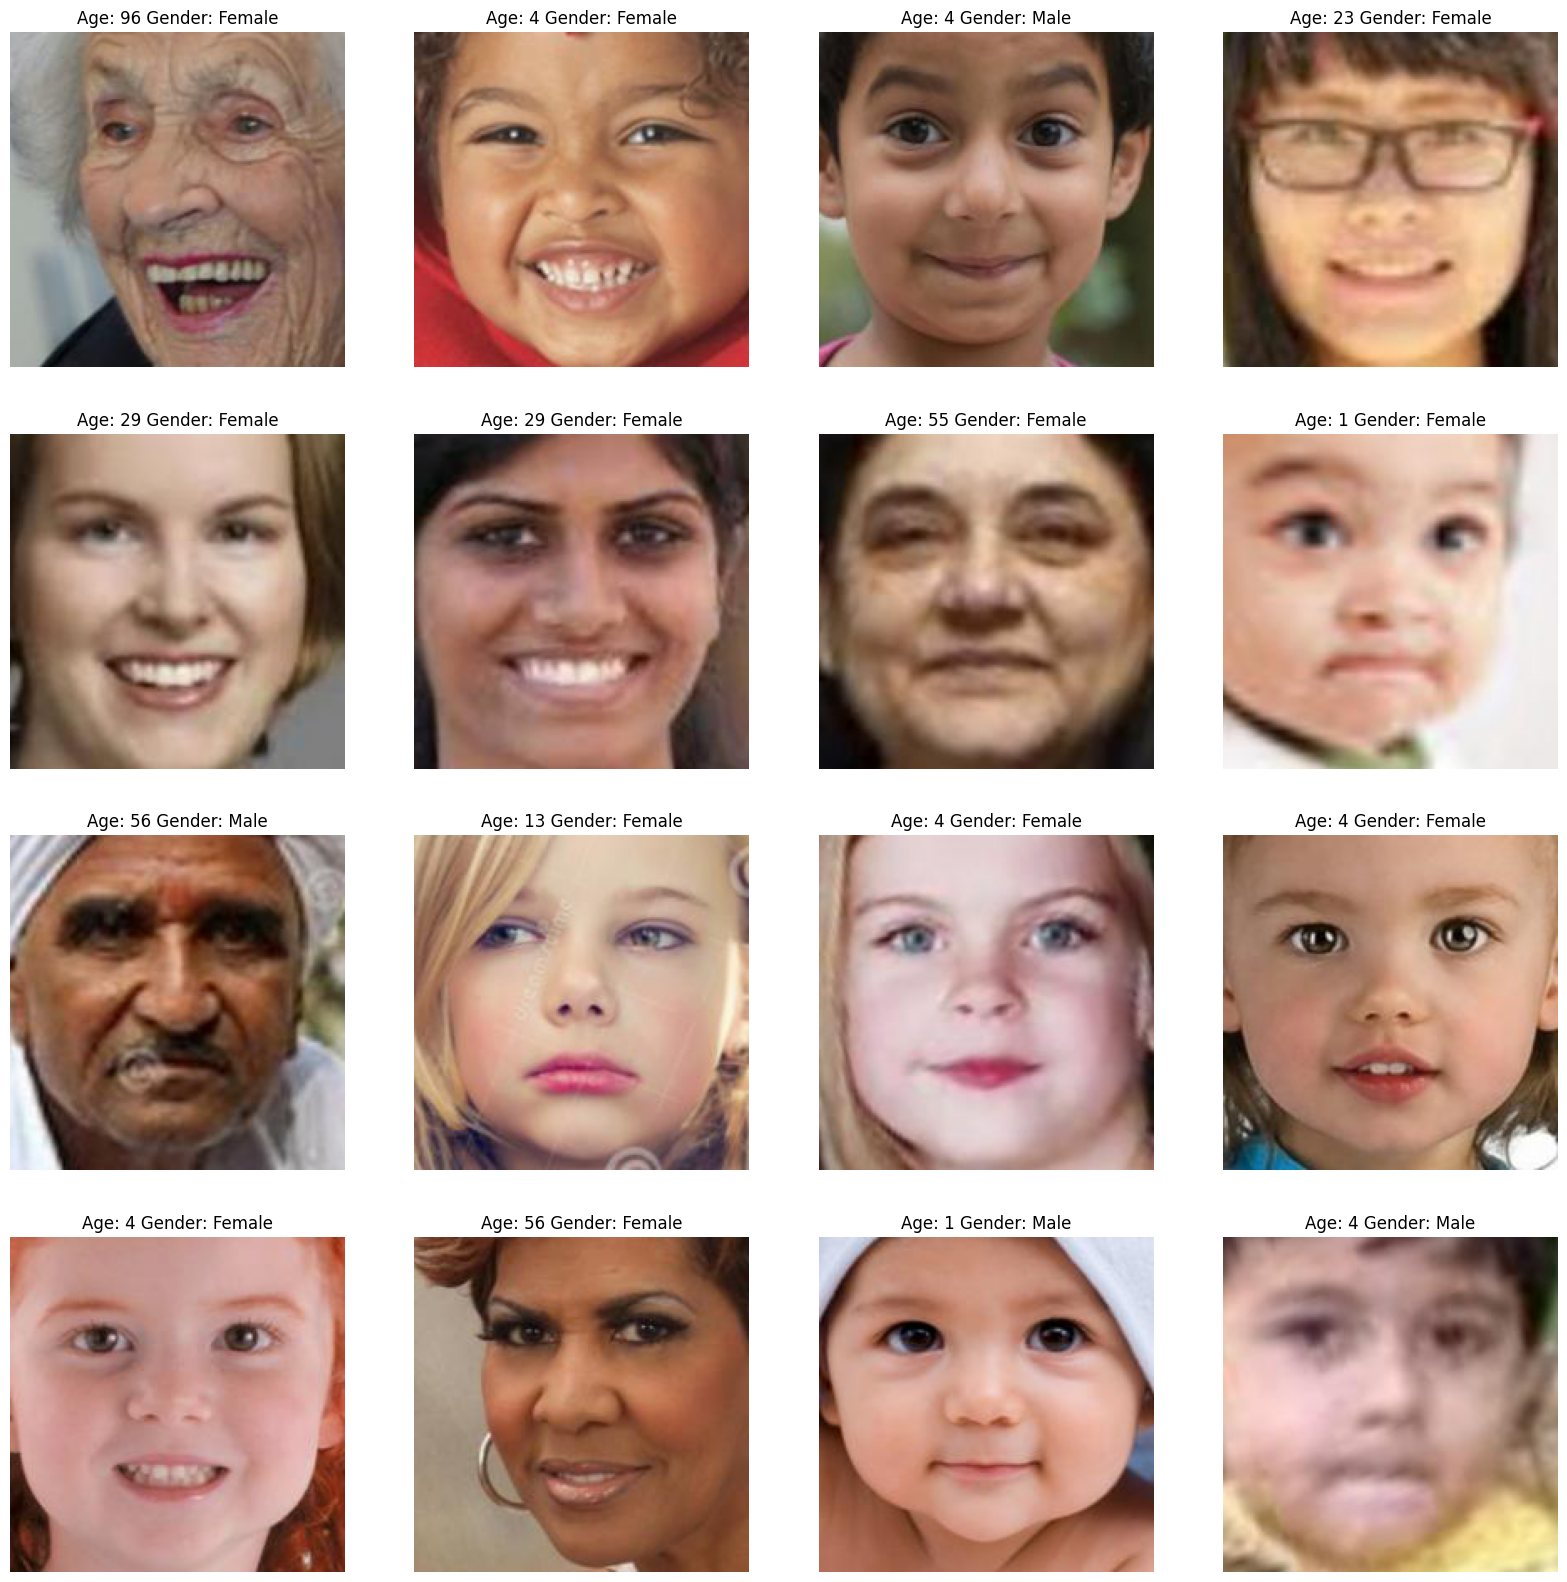

In [11]:
plt.figure(figsize=(20, 20))
samples = df.iloc[0:16]

for index, sample, age, gender in samples.itertuples():
    plt.subplot(4, 4, index + 1)
    img = load_img(sample)
    img = np.array(img)
    plt.axis('off')
    plt.title(f'Age: {age} Gender: {gender_mapping[gender]}')
    plt.imshow(img)

In [12]:
def extract_image_features(images):
    features = list()

    for image in tqdm(images):
        img = load_img(image, grayscale=True)
        img = img.resize((128, 128), Image.ANTIALIAS)
        img = np.array(img)
        features.append(img)

    features = np.array(features)
    features = features.reshape(len(features), 128, 128, 1)
    return features

In [13]:
X = extract_image_features(df['image_path'])

  0%|          | 0/1090 [00:00<?, ?it/s]

In [14]:
X.shape

(1090, 128, 128, 1)

In [15]:
X = X / 255.0

In [16]:
y_gender = np.array(df['gender'])
y_age = np.array(df['age'])

In [17]:
input_shape = (128, 128, 1)

In [18]:
inputs = Input((input_shape))
conv_1 = Conv2D(32, kernel_size=(3, 3), activation='relu')(inputs)
max_1 = MaxPooling2D(pool_size=(2, 2))(conv_1)
conv_2 = Conv2D(64, kernel_size=(3, 3), activation='relu')(max_1)
max_2 = MaxPooling2D(pool_size=(2, 2))(conv_2)
conv_3 = Conv2D(128, kernel_size=(3, 3), activation='relu')(max_2)
max_3 = MaxPooling2D(pool_size=(2, 2))(conv_3)
conv_4 = Conv2D(256, kernel_size=(3, 3), activation='relu')(max_3)
max_4 = MaxPooling2D(pool_size=(2, 2))(conv_4)

flatten = Flatten()(max_4)

# fully connected layers
dense_1 = Dense(256, activation='relu')(flatten)
dense_2 = Dense(256, activation='relu')(flatten)

dropout_1 = Dropout(0.3)(dense_1)
dropout_2 = Dropout(0.3)(dense_2)

output_1 = Dense(1, activation='sigmoid', name='gender_out')(dropout_1)
output_2 = Dense(1, activation='relu', name='age_out')(dropout_2)

model = Model(inputs=[inputs], outputs=[output_1, output_2])

model.compile(loss=['binary_crossentropy', 'mae'],
              optimizer='adam', metrics=['accuracy'])

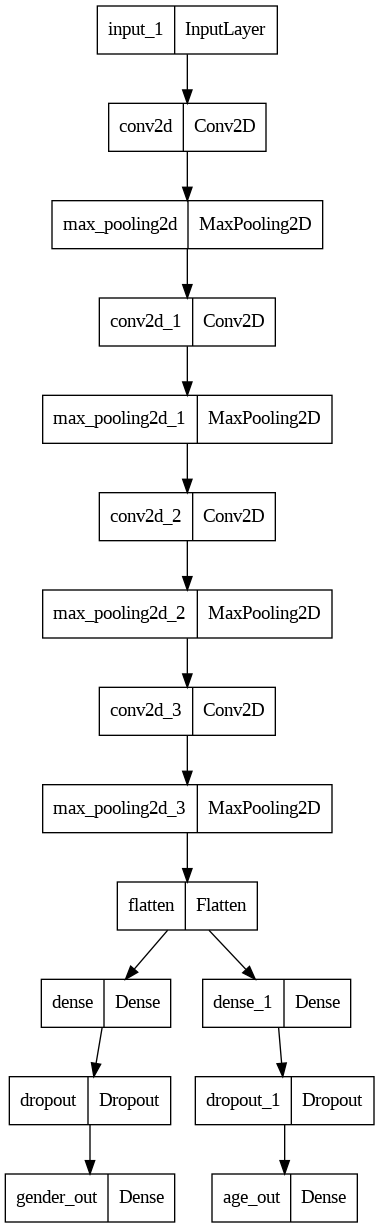

In [19]:
# plot the model
from tensorflow.keras.utils import plot_model
plot_model(model)

In [20]:
history = model.fit(x=X, y=[y_gender, y_age],
                    batch_size=32, epochs=50, validation_split=0.2)

Epoch 1/50
28/28 [==============================] - 14s 51ms/step - loss: 25.3916 - gender_out_loss: 0.7792 - age_out_loss: 24.6124 - gender_out_accuracy: 0.5608 - age_out_accuracy: 0.1399 - val_loss: 21.8583 - val_gender_out_loss: 0.7375 - val_age_out_loss: 21.1208 - val_gender_out_accuracy: 0.4174 - val_age_out_accuracy: 0.1560
Epoch 2/50
28/28 [==============================] - 1s 20ms/step - loss: 25.1251 - gender_out_loss: 0.7158 - age_out_loss: 24.4092 - gender_out_accuracy: 0.5413 - age_out_accuracy: 0.1445 - val_loss: 23.1619 - val_gender_out_loss: 0.6838 - val_age_out_loss: 22.4780 - val_gender_out_accuracy: 0.5826 - val_age_out_accuracy: 0.1560
Epoch 3/50
28/28 [==============================] - 1s 20ms/step - loss: 25.0234 - gender_out_loss: 0.6759 - age_out_loss: 24.3476 - gender_out_accuracy: 0.6284 - age_out_accuracy: 0.1445 - val_loss: 22.5163 - val_gender_out_loss: 0.7060 - val_age_out_loss: 21.8102 - val_gender_out_accuracy: 0.5826 - val_age_out_accuracy: 0.1560
Epoch 

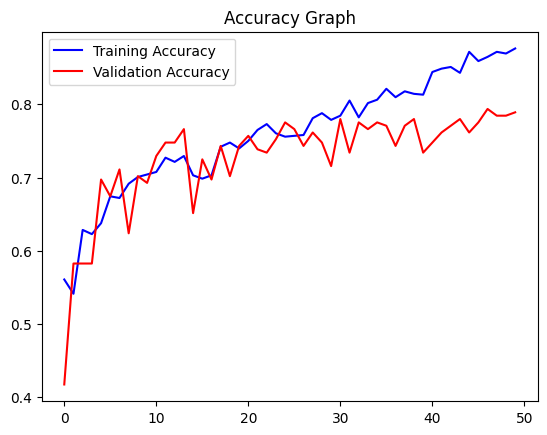

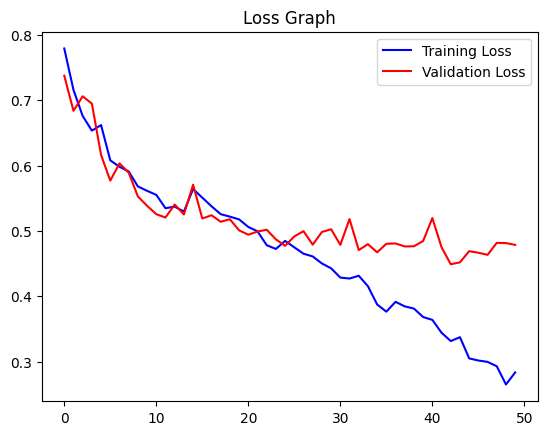

In [21]:
# plot results for gender
acc = history.history['gender_out_accuracy']
val_acc = history.history['val_gender_out_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['gender_out_loss']
val_loss = history.history['val_gender_out_loss']

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

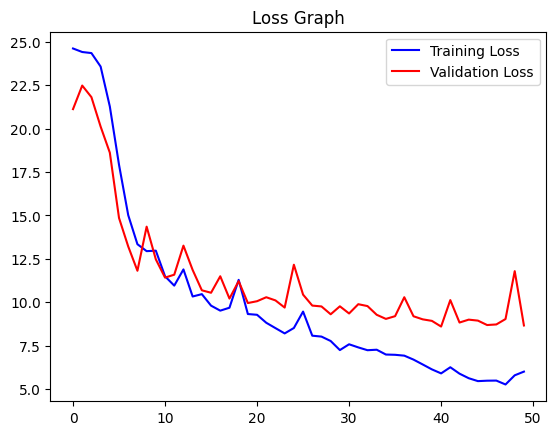

In [22]:
# plot results for age
loss = history.history['age_out_loss']
val_loss = history.history['val_age_out_loss']
epochs = range(len(loss))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()
plt.show()

In [23]:
def get_image_features(image):
  img = load_img(image, grayscale=True)
  img = img.resize((128, 128), Image.ANTIALIAS)
  img = np.array(img)
  img = img.reshape(1, 128, 128, 1)
  img = img / 255.0
  return img

1/1 [==============================] - 1s 549ms/step


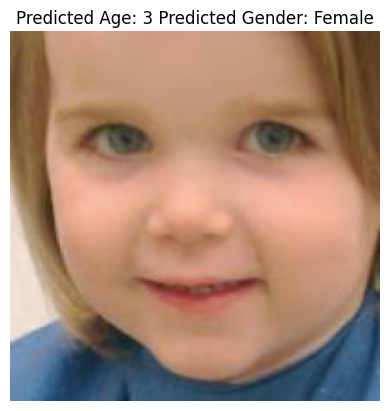

In [25]:
img_to_test = '/content/4_1_0_20170109190923998.jpg.chip.jpg'
features = get_image_features(img_to_test)
pred = model.predict(features)
gender = gender_mapping[round(pred[0][0][0])]
age = round(pred[1][0][0])

plt.title(f'Predicted Age: {age} Predicted Gender: {gender}')
plt.axis('off')
plt.imshow(np.array(load_img(img_to_test)))